<a href="https://colab.research.google.com/github/Iyanuadeleye01/AI-Driven-3D-Medical-Imaging/blob/main/lung_segmentation_from_chest_x_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lung segmentation from Chest X-Ray dataset

**About the data**:
- The dataset is made up of images and segmentated mask from two diffrent sources.
- There is a slight abnormality in naming convention of masks.
- Some images don't have their corresponding masks.
- Images from the Shenzhen dataset has apparently smaller lungs as compared to the Montgomery dataset.


## Take a look at the dataset

In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from google.colab import drive
from zipfile import ZipFile
import matplotlib.pyplot as plt

drive.mount('/content/drive')

image_path = "/content/drive/MyDrive/3D_lung_data/Lung Segmentation/CXR_png"
mask_path = "/content/drive/MyDrive/3D_lung_data/Lung Segmentation/masks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls /content/drive/MyDrive/3D_lung_data

 data  'Lung Segmentation'


In [6]:
!ls "/content/drive/MyDrive/3D_lung_data/Lung Segmentation"


ClinicalReadings  masks			       NLM-MontgomeryCXRSet-ReadMe.pdf
CXR_png		  NLM-ChinaCXRSet-ReadMe.docx  test



They can inspected the concerning dataset seperately [here](http://https://www.kaggle.com/kmader/pulmonary-chest-xray-abnormalities/home).

In [7]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images = glob(os.path.join(image_path, '*.png'))
mask = glob(os.path.join(mask_path, '*.png'))
mask = [os.path.basename(fName).split(".png")[0] for fName in mask]
image_file_name = [os.path.basename(fName).split("_mask")[0] for fName in mask]

In [8]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


Earlier I was going to train on the Shenzhen dataset while perform prediction on the Montgomery dataset. However, the nature of the data was diffrent in both the set. The images from Shenzhen dataset had smaller lung-to-image ratio as compared to the Montgomery dataset.

Thus, I am loading the two dataset seperately which I combined once I got to know about the disparity.

In [9]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images_list = glob(os.path.join(image_path, '*.png'))
mask_list = glob(os.path.join(mask_path, '*.png'))

# Create a mapping from image file name to mask file name
mask_dict = {os.path.basename(fName).split("_mask")[0]: fName for fName in mask_list}

# Filter images to keep only those with corresponding masks
testing_files = [fName for fName in images_list if os.path.basename(fName).split(".png")[0] in mask_dict]

# The training files are the same as the testing files in this case, as we are using all images with masks
training_files = testing_files


def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []

    if flag == "test":
        for i in tqdm(testing_files):
            # Construct the mask file path using the mask_dict
            mask_file = mask_dict[os.path.basename(i).split(".png")[0]]
            im = cv2.resize(cv2.imread(i),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(mask_file),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

    if flag == "train":
        for i in tqdm(training_files):
            # Construct the mask file path using the mask_dict
            mask_file = mask_dict[os.path.basename(i).split(".png")[0]]
            im = cv2.resize(cv2.imread(i),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(mask_file),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [10]:
#perform sanity check

def plotMask(X,y):
    sample = []

    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)


    for i in range(0,6,3):

        plt.figure(figsize=(25,10))

        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])

        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])


        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])

        plt.show()

In [11]:
# Load training and testing data
dim = 256
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 566/566 [01:29<00:00,  6.31it/s]


# Perform Sanity Check

It is prudent to perform sanity check of the data correspondance. It become a routine check-up after a while but it is very crucial to check if we had made a mistake in loading the data.

training set


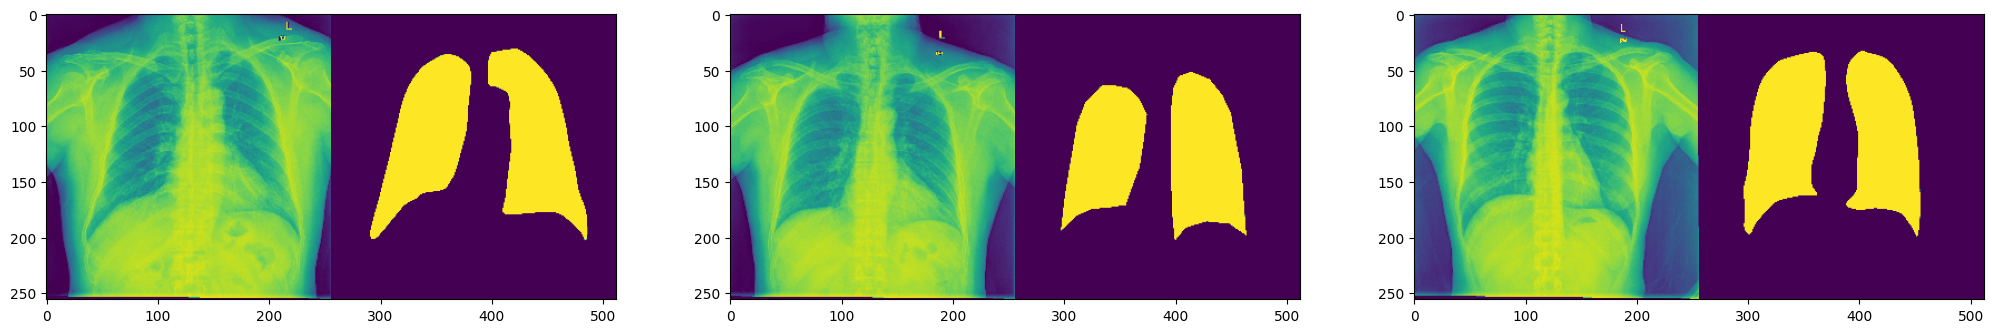

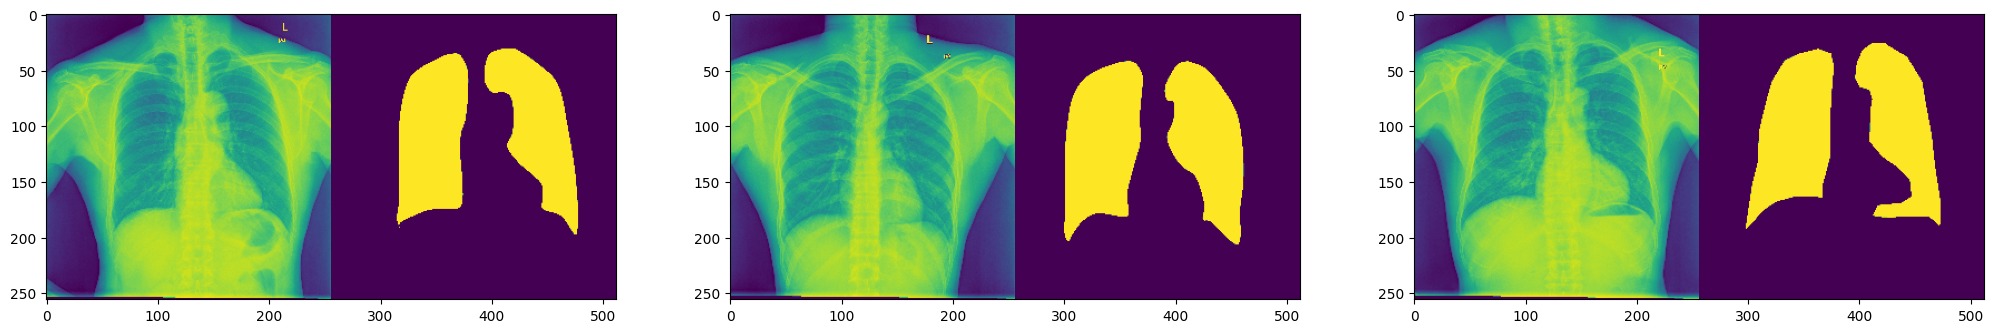

testing set


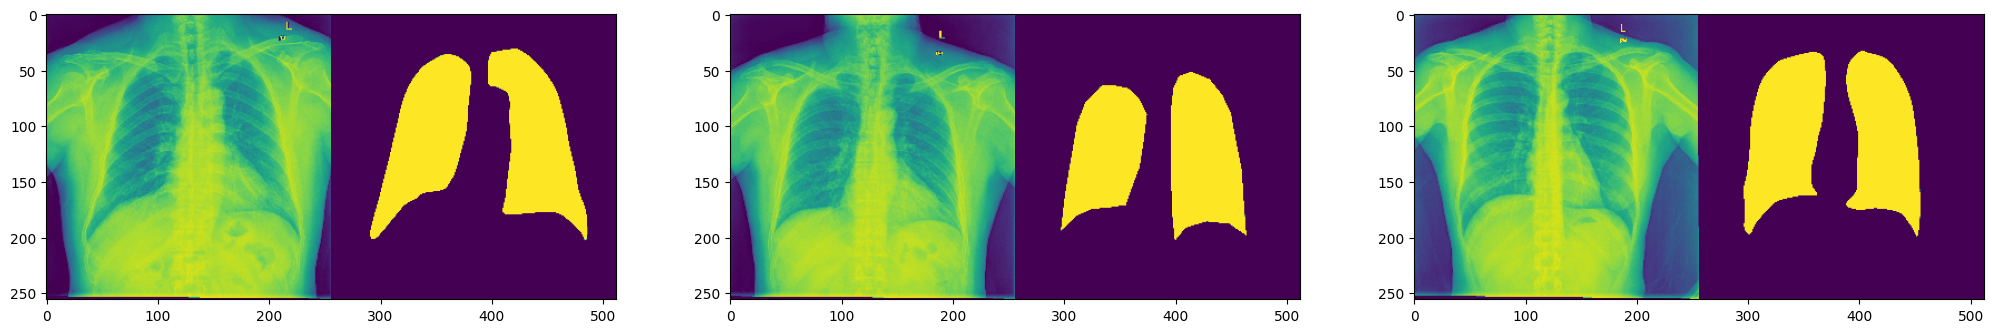

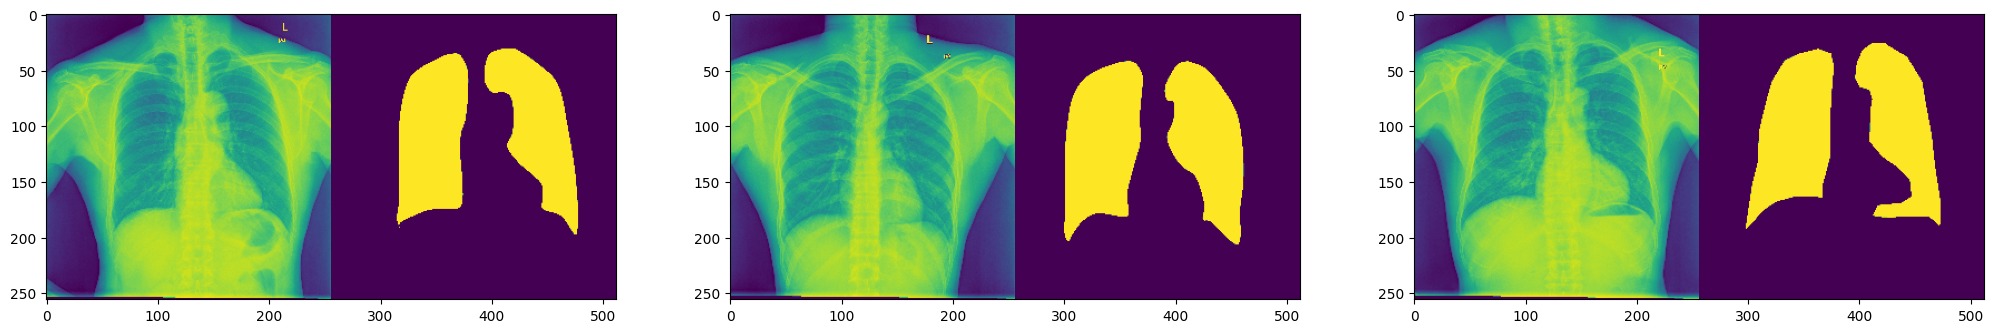

In [12]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

Both the sets looks correct. Let's combine them and further use them as a unified dataset.

In [13]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

## Define  the network and callbacks

I am going to use my favourite segmentation network - U-Nets. You can read about them [here](https://arxiv.org/abs/1505.04597).

In [14]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow as tf


def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

#### Compile and train the Unet Model

In [18]:
model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_19[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_25[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_27[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │    524,544 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

## Callbacks, Early Stopping and Reduced LR


In [19]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.weights.h5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

#### Train the model

I intially used a 60-40 train-test spit and got a loss of -0.97. However, the better way to do it is 80-10-10 train-test-validation spit. Below I am roughly doing the later.

In [20]:
from IPython.display import clear_output
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=[dice_coef_loss],
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0,
                                                            (mask>127).astype(np.float32),
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg,
                                                            test_size = 0.1,
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 4,
                  epochs = 20,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)


clear_output()

## Plot the metric and evaluate

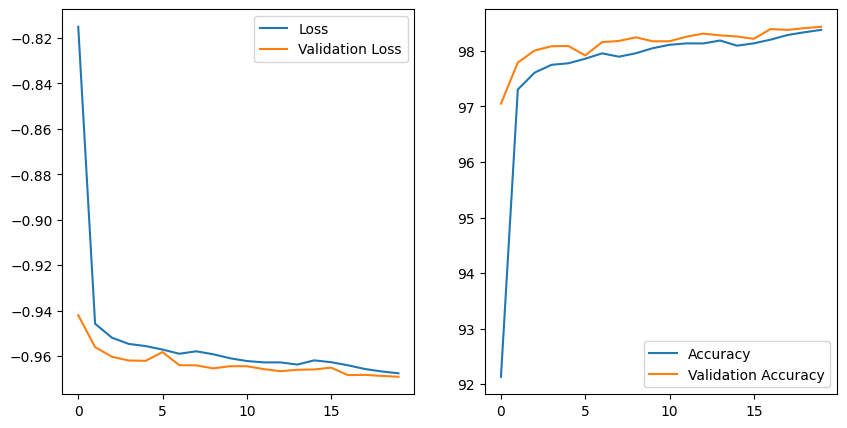

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-',
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

## Test the model

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(32, 256, 256, 1))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step


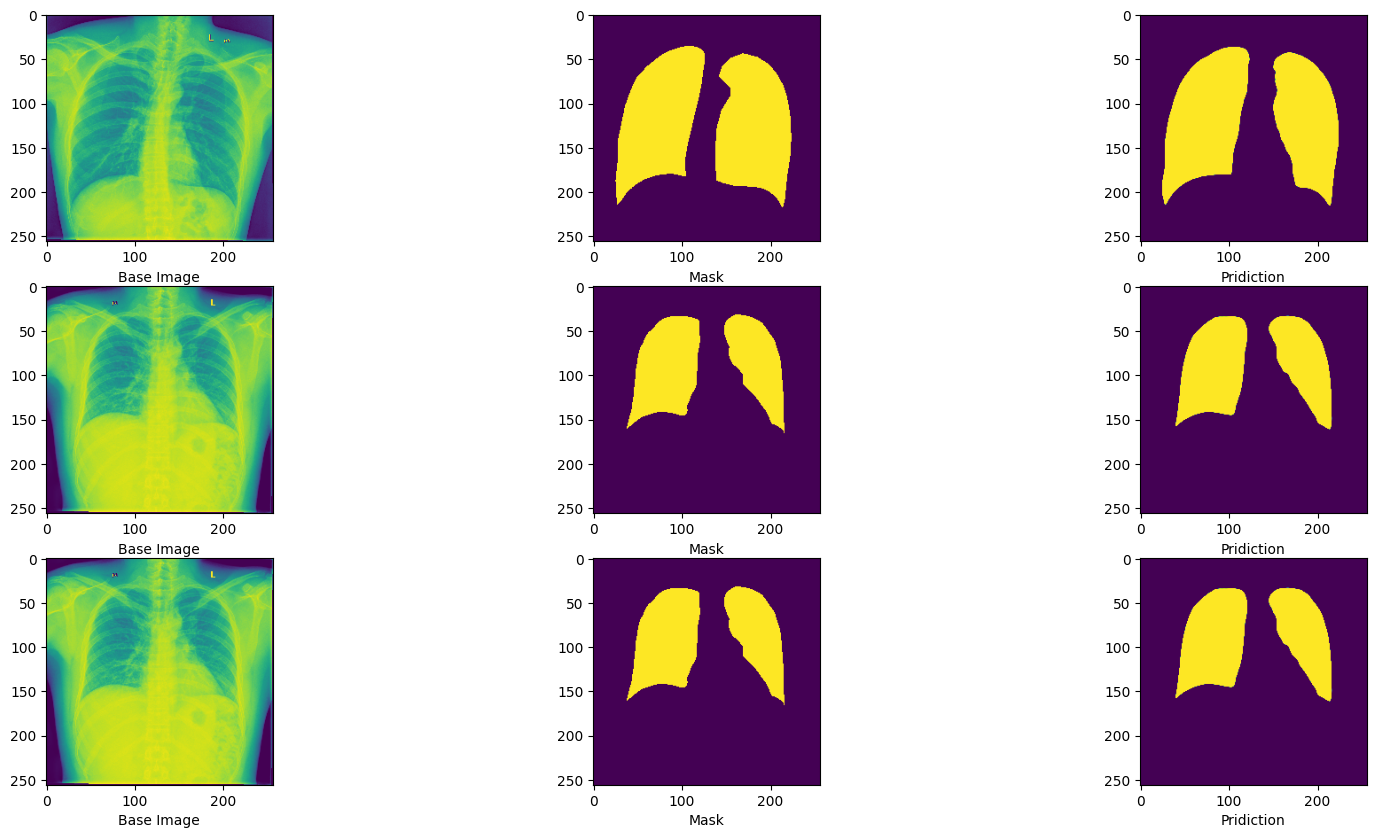

In [22]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)

    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")


    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")

    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")

In [23]:
import os

print("Contents of image_path:")
try:
    print(os.listdir(image_path)[:10]) # Print first 10 items
except FileNotFoundError:
    print(f"Error: image_path '{image_path}' not found.")

print("\nContents of mask_path:")
try:
    print(os.listdir(mask_path)[:10]) # Print first 10 items
except FileNotFoundError:
    print(f"Error: mask_path '{mask_path}' not found.")

Contents of image_path:
['CHNCXR_0001_0.png', 'CHNCXR_0002_0.png', 'CHNCXR_0003_0.png', 'CHNCXR_0004_0.png', 'CHNCXR_0005_0.png', 'CHNCXR_0006_0.png', 'CHNCXR_0007_0.png', 'CHNCXR_0008_0.png', 'CHNCXR_0009_0.png', 'CHNCXR_0010_0.png']

Contents of mask_path:
['CHNCXR_0001_0_mask.png', 'CHNCXR_0002_0_mask.png', 'CHNCXR_0003_0_mask.png', 'CHNCXR_0004_0_mask.png', 'CHNCXR_0005_0_mask.png', 'CHNCXR_0006_0_mask.png', 'CHNCXR_0007_0_mask.png', 'CHNCXR_0008_0_mask.png', 'CHNCXR_0009_0_mask.png', 'CHNCXR_0010_0_mask.png']
